In [1]:
import pyspark
import pandas as pd

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
2,application_1574131643964_0003,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

No module named 'matplotlib'
Traceback (most recent call last):
ModuleNotFoundError: No module named 'matplotlib'



In [17]:
# sc.install_pypi_package("matplotlib") #might need to install the matplotlib since it's not included in the bootstrap
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Project Birth Analysis - Part I: Preprocessing:

####  Kevin Phan 

### 1. Problem Presentation:

Every year, there are millions of birth in the United States. Apart from traditional natal research, an empirical research could be conducted to understand what element could contribute to a successful childbirth. The [National Center for Health Statistics](https://www.cdc.gov/nchs/) is regularly maintaining a Vital Statistics Natality Birth Data where demographic and health data from yearly birth is collected from birth certificate.

According to  [National Bureau of Economic Research](http://www.nber.org/data/vital-statistics-natality-data.html) (NBER), the data set includes...

>Demographic data include variables such as date of birth, age and educational attainment of parents, marital status, live-birth order, race, sex, and geographic area. Health data include items such as birth weight, gestation, prenatal care, attendant at birth, and Apgar score. Geographic data includes state, county, city (available for cities of 250,000+ (up to 1980) and 100,000+ (1980-)), SMSA (1980-), and metropolitan and nonmetropolitan counties. 

By conducting data mining analysis on this dataset, a better understanding of what could contribute to a successful birth or lead to adverse event. Potentially, a clasification could be conducted with the target is childbirth mortality could be beneficial in terms of reducing the mortality rate in such a complication procedure like childbirth and decrease the economic burden


### 2. Method of Analysis:

- Due to the colossal nature of the dataset (millions of record yearly), one year is picked to conduct the analysis and test the feasibility of the model/hypothesis. Therefore, the most recent data **2017** is retrieved from the [NBER](http://www.nber.org/data/vital-statistics-natality-data.html) and re-uploaded to S3 Cluster (2.2GB csv format)
- The **Variable Description (metadata)** of this dataset is referenced from [here](http://www.nber.org/natality/2017/natl2017.pdf)
- Since this data is very high dimensional (>200 columns), we employed a backwards data analyis: data *visualization/summarization is conducted before cleaning* to better understanding the dataset since it is a new domain to us. Then possible meaningful variables would be kept for building the model - and cleaning will be conducted only to those variables.
- Data Mining (anticipated): A Logistic Regression would be conducted with the target variable is the mortality (Infant Living at Time of Report Y/N - (`ilive`)and the dependent variables could be grouped into:
    1. Parents Demographic: Mother Age (`mager`), Father Age (`fage`), Mother's BMI (`bmi`)
    2. Mothers Life Style and Conditions: Number of Prenatal Visits (`previs`), Cigarette Usage (Prenatal and during Trimester), Infertility Treament Used (`rf_inftr`), Any Infections Reported eg. Gonorrhea, Syphillis, Hep BC... (`no_infec`)
    3. Labor Process: Birthing Facility Used (`f_facility`), Route of Delivery (`me_rout`),Induction of Labor (`ld_indl`)
    
 

### A. Data Loading:

In [2]:
#Load Dataset from S3 Bucket
birth = (
spark
.read
.csv(
's3://cis4567-binhdinh/vital/natl2017.csv'
, header=True
, inferSchema=True)
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
rows = birth.count()
print('There are {} rows in the dataset'.format(rows))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

There are 3864754 rows in the dataset

In [4]:
birth.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- dob_yy: integer (nullable = true)
 |-- dob_mm: integer (nullable = true)
 |-- dob_tt: integer (nullable = true)
 |-- dob_wk: integer (nullable = true)
 |-- bfacil: integer (nullable = true)
 |-- f_facility: integer (nullable = true)
 |-- bfacil3: integer (nullable = true)
 |-- mage_impflg: integer (nullable = true)
 |-- mage_repflg: integer (nullable = true)
 |-- mager: integer (nullable = true)
 |-- mager14: integer (nullable = true)
 |-- mager9: integer (nullable = true)
 |-- mbstate_rec: integer (nullable = true)
 |-- restatus: integer (nullable = true)
 |-- mrace31: integer (nullable = true)
 |-- mrace6: integer (nullable = true)
 |-- mrace15: integer (nullable = true)
 |-- mbrace: integer (nullable = true)
 |-- mraceimp: integer (nullable = true)
 |-- mhisp_r: integer (nullable = true)
 |-- f_mhisp: integer (nullable = true)
 |-- mracehisp: integer (nullable = true)
 |-- mar_p: string (nullable = true)
 |-- dmar: integer (nullable = true)
 |-- mar_imp: integer (nullable 

### B. Cleaning data:

#### 1. Duplicated Value (Not Applicable):

Since there is not unique identifier to determine duplicated value, and the size of data set, duplicated remove seems not neccessary. Furthermore, with such an imbalance dataset, oversampling/undersampling of data might be considered. Therefore remove duplication is not applicable to this dataset

#### 2. Data Visualization: 

Since it is a big dataset, for the purpose of descriptive analysis, before cleaning the data, notable variables will be analyze to get a grasp on the distribution of the data and understand what variable can be used for modeling

In [6]:
import numpy as np
#get the histogram count for potential variables
histogram_mother_Age = (birth.select('mager').rdd.flatMap(lambda record: record).histogram(np.linspace(0,80,15).round(1).tolist()))
birth_facility = (birth.select('BFACIL').rdd.flatMap(lambda record: record).histogram(9))
delivery_route = (birth.select('me_rout').rdd.flatMap(lambda record: record).histogram(9))


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### a) Distribution of Mother and Father Age:

- It seems that Mother and Father follows similar distribution. The slight difference is Mother's Age distribution is slightly skewed to the right where Father's Age is skewed to the left which is explainable. We would choose only Mother age for modeling due to similarity of the two distribution.

- As the descriptive_states show, there is outlier is 99, which is indicated as `Unknown`. Therefore, before generating the histogram for father age, `99` value is remove

In [85]:
descriptive_stats = birth.describe(['mager','fagecomb'])
descriptive_stats.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----------------+------------------+
|summary|            mager|          fagecomb|
+-------+-----------------+------------------+
|  count|          3864754|           3864754|
|   mean|28.84684380946368| 39.65671683113595|
| stddev|5.815096482773846|22.674596561284474|
|    min|               12|                 1|
|    max|               50|                99|
+-------+-----------------+------------------+

In [11]:
%%spark -o hist_M_Age 

hist_M_Age =  spark.createDataFrame(
    list(zip(*histogram_mother_Age)), 
    ['bins', 'counts'])



FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

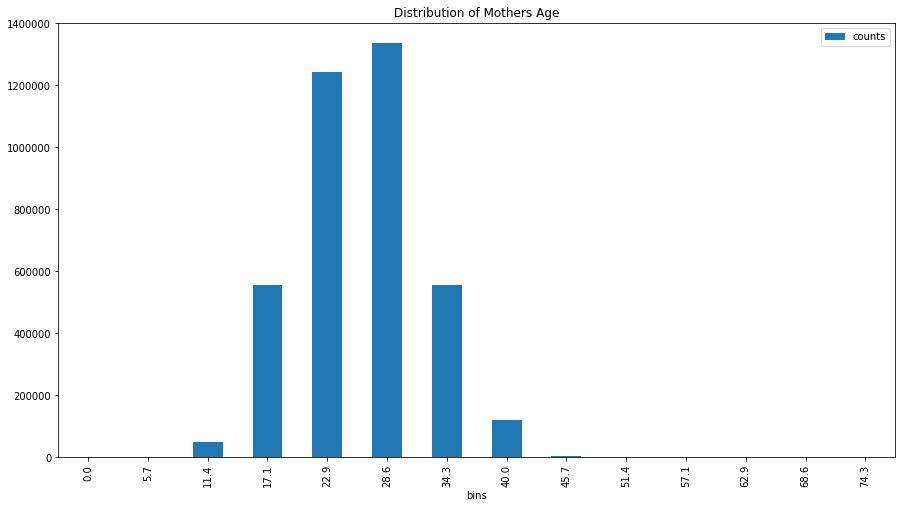

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

hist_M_Age.set_index('bins'
            ).plot(kind='bar',figsize=(15,8))
plt.title('Distribution of Mother''s Age')
plt.show()

In [87]:
#Remove 99 value, which is Unknown
histogram_father_Age = (birth.filter(birth.fagecomb !=99).
                        select('fagecomb').rdd.flatMap(lambda record: record).
                        histogram(np.linspace(0,80,15).round(1).tolist()))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [88]:
%%spark -o hist_F_Age

hist_F_Age =  spark.createDataFrame(
    list(zip(*histogram_father_Age)), 
    ['bins', 'counts'])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

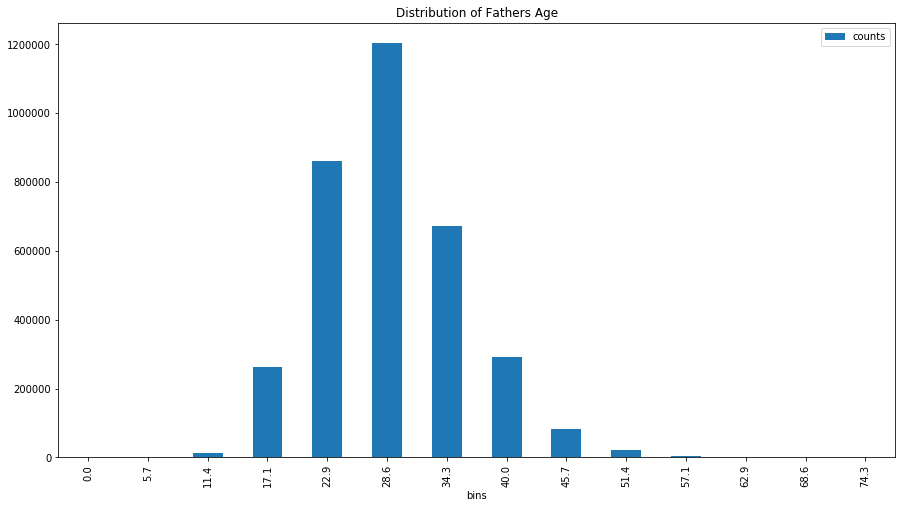

In [89]:
%matplotlib inline
hist_F_Age.set_index('bins'
            ).plot(kind='bar',figsize=(15,8))
plt.title('Distribution of Father''s Age')
plt.show()

#### b) Pre-natal visits:
- The most popular number of prenatal doctor visit is 11 (while mean is 13.5), which is resemble to Doctor's recommendation:
>- Weeks 4 to 28: 1 prenatal visit a month.
 - Weeks 28 to 36: 1 prenatal visit every 2 weeks. 
 - Weeks 36 to 40: 1 prenatal visit every week.
 [Source](https://www.webmd.com/baby/how-often-do-i-need-prenatal-visits)
 
- Again the `max` value is `99` and by checking the data dictionary, this is unknown so it is excluded when histogram is being made
- This data is quitely skewed to the right where there are many outliers where expected mother would make more than 40 visits to docor (approximately equivalent to once a week). However, these data would not be exclude in the model, since there might indicate that the mother has many pre-existing condition?

In [96]:
descriptive_stats = birth.describe(['previs'])
descriptive_stats.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------------+
|summary|            previs|
+-------+------------------+
|  count|           3864754|
|   mean| 13.51411706928824|
| stddev|14.397170521938676|
|    min|                 0|
|    max|                99|
+-------+------------------+

In [97]:
#filter 99 value
pre_vis = (birth.filter(birth.previs != 99).
           select('previs').rdd.flatMap(lambda record: record).histogram(np.linspace(0,100,20).round().tolist()))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [98]:
%%spark -o hist_prenatal_visits 

hist_prenatal_visits =  spark.createDataFrame(
    list(zip(*pre_vis)), 
    ['bins', 'counts'])


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

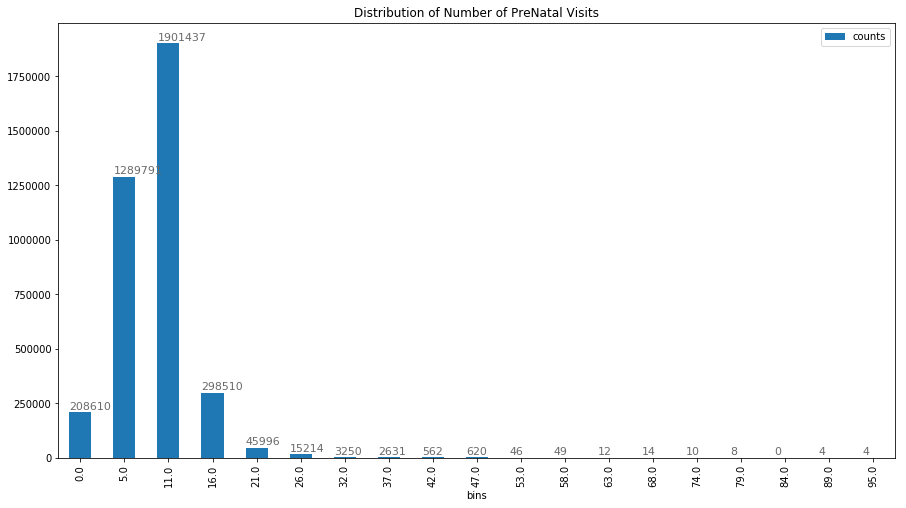

In [99]:
%matplotlib inline
ax = hist_prenatal_visits.set_index('bins'
            ).plot(kind='bar',figsize=(15,8))
plt.title('Distribution of Number of PreNatal Visits')
for i in ax.patches:
    ax.text(i.get_x(), i.get_height()+13000, \
            str(round((i.get_height()), 2)), fontsize=11, color='dimgrey',
                )
plt.show()

#### c)  Mother's Smoking Habit :

The dataset also reports number of daily cigarette of mothers before and during 3 tri-mester of pregnancy. Surprisingly, the distribution is not too different between cigarette habit before or during the trimester looking at the histogram. For future analysis, it might worth to just use one variable only since it might strongly correlated with each other.


In [100]:
descriptive_stats = birth.describe(['cig_0','cig_1','cig_2','cig_3'])
descriptive_stats.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------------+------------------+------------------+------------------+
|summary|             cig_0|             cig_1|             cig_2|             cig_3|
+-------+------------------+------------------+------------------+------------------+
|  count|           3864754|           3864754|           3864754|           3864754|
|   mean|1.6602650517988984|1.2076321028453558|1.0351466095901576|0.9693393162928352|
| stddev|  8.39568411805555| 7.719377269321902| 7.512743222045808| 7.437904068945614|
|    min|                 0|                 0|                 0|                 0|
|    max|                99|                99|                99|                99|
+-------+------------------+------------------+------------------+------------------+

In [101]:
condition_null = (birth.cig_0 !=99) & (birth.cig_1 !=99) & (birth.cig_2 !=99) & (birth.cig_3 !=99)
cigarette_before_pregnancy = (birth.filter(condition_null).select('cig_0').rdd.flatMap(lambda record: record).histogram(np.linspace(0,50,15).round().tolist()))
cigarette_1sttrimester = (birth.filter(condition_null).select('cig_1').rdd.flatMap(lambda record: record).histogram(np.linspace(0,50,15).round().tolist()))
cigarette_2ndtrimester = (birth.filter(condition_null).select('cig_2').rdd.flatMap(lambda record: record).histogram(np.linspace(0,50,15).round().tolist()))
cigarette_3rdtrimester = (birth.filter(condition_null).select('cig_3').rdd.flatMap(lambda record: record).histogram(np.linspace(0,50,15).round().tolist()))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [25]:
%%spark -o hist_prepreg_cig

hist_prepreg_cig =  spark.createDataFrame(
    list(zip(*cigarette_before_pregnancy)), 
    ['bins', 'counts'])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

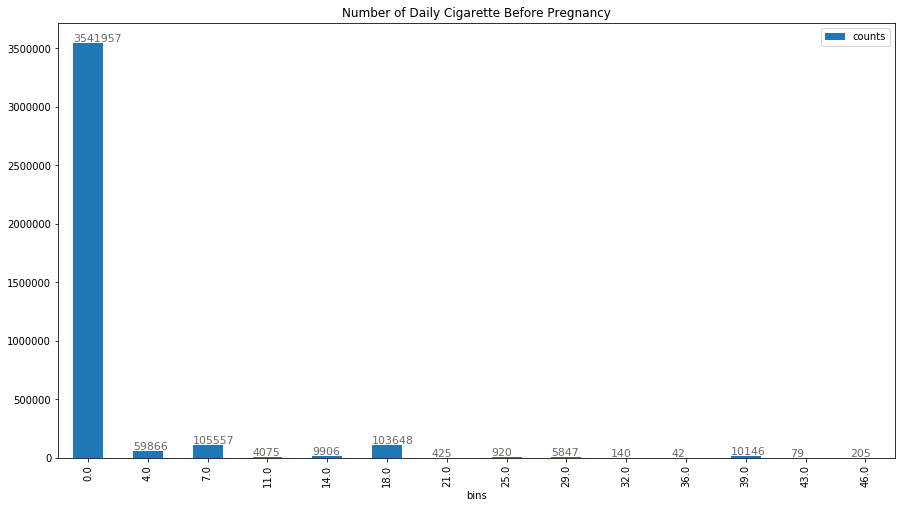

In [102]:
%matplotlib inline

ax=hist_prepreg_cig.set_index('bins'
            ).plot(kind='bar',figsize=(15,8))
for i in ax.patches:
    ax.text(i.get_x(), i.get_height()+13000, \
            str(round((i.get_height()), 2)), fontsize=11, color='dimgrey',
                )
plt.title('Number of Daily Cigarette Before Pregnancy')
plt.show()

In [103]:
%%spark -o hist_1stpreg_cig

hist_1stpreg_cig =  spark.createDataFrame(
    list(zip(*cigarette_1sttrimester)), 
    ['bins', 'counts'])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

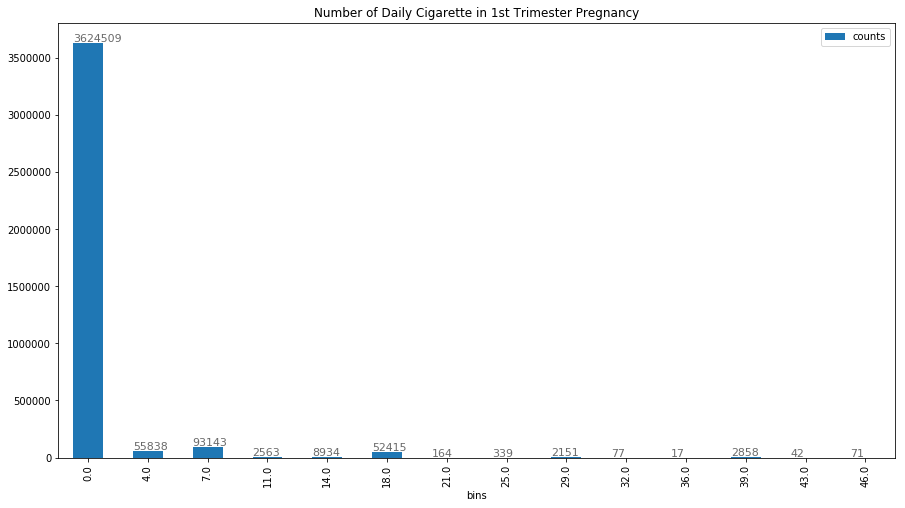

In [104]:
%matplotlib inline
ax = hist_1stpreg_cig.set_index('bins'
            ).plot(kind='bar',figsize=(15,8))
for i in ax.patches:
    ax.text(i.get_x(), i.get_height()+13000, \
            str(round((i.get_height()), 2)), fontsize=11, color='dimgrey',
                )
plt.title('Number of Daily Cigarette in 1st Trimester Pregnancy')
plt.show()

In [105]:
%%spark -o hist_2ndpreg_cig

hist_2ndpreg_cig =  spark.createDataFrame(
    list(zip(*cigarette_2ndtrimester)), 
    ['bins', 'counts'])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

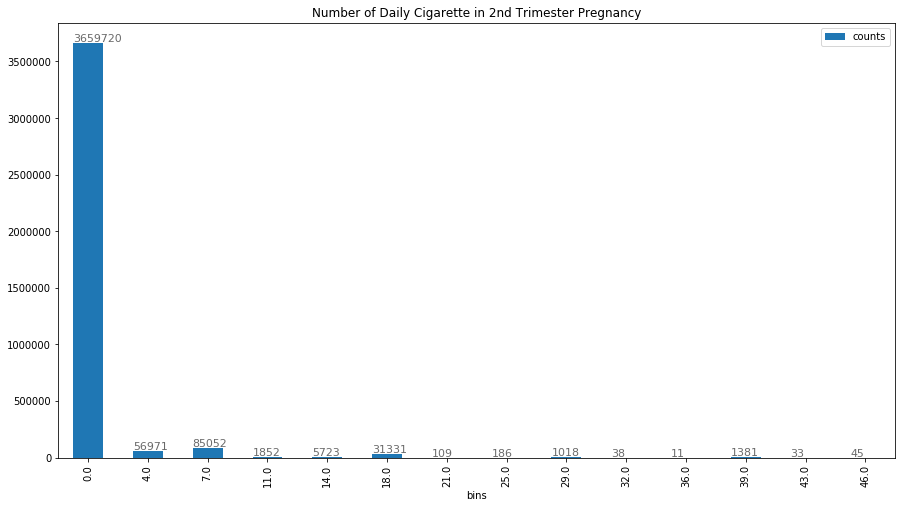

In [106]:
%matplotlib inline
ax = hist_2ndpreg_cig.set_index('bins'
            ).plot(kind='bar',figsize=(15,8))
for i in ax.patches:
    ax.text(i.get_x(), i.get_height()+13000, \
            str(round((i.get_height()), 2)), fontsize=11, color='dimgrey',
                )
plt.title('Number of Daily Cigarette in 2nd Trimester Pregnancy')
plt.show()

In [107]:
%%spark -o hist_3rdpreg_cig

hist_3rdpreg_cig =  spark.createDataFrame(
    list(zip(*cigarette_3rdtrimester)), 
    ['bins', 'counts'])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

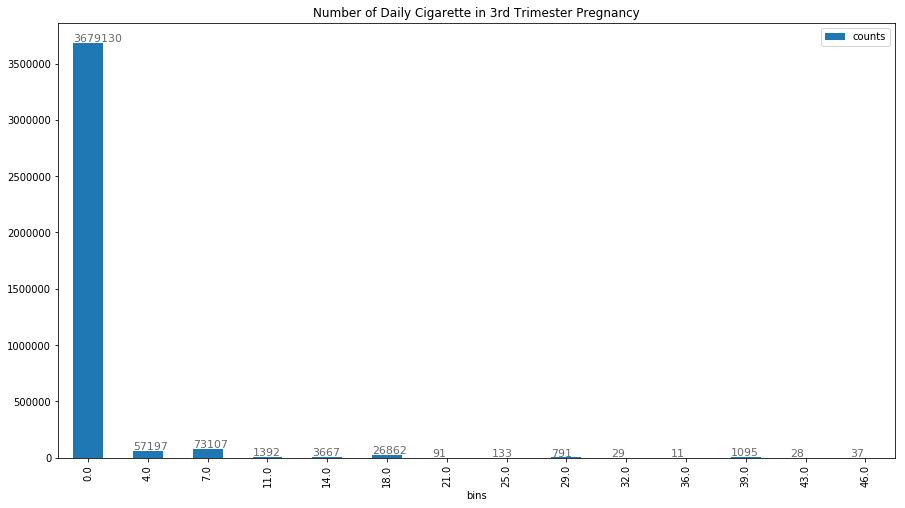

In [108]:
%matplotlib inline
ax = hist_3rdpreg_cig.set_index('bins'
            ).plot(kind='bar',figsize=(15,8))
for i in ax.patches:
    ax.text(i.get_x(), i.get_height()+13000, \
            str(round((i.get_height()), 2)), fontsize=11, color='dimgrey',
                )
plt.title('Number of Daily Cigarette in 3rd Trimester Pregnancy')
plt.show()

#### c)  Birth's Facility and Mean of Delivery

Homebirth is not a popular mean of delivery in the US as proven from the dataset (which is totally contrast to countries like U.K or Australia where homebirth is a viable option for qualified mother). Due to the majority of data values fall into Hospital, this variable would not be used in modeling

Also, the two most popular means of delivery are Spontaneous and C-Section. We can coded All Other as Other's as a way to reduce the dimensionality


In [35]:
%%spark -o hist_birth_facility

hist_birth_facility =  spark.createDataFrame(
    list(zip(*birth_facility)), 
    ['bins', 'counts'])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[]

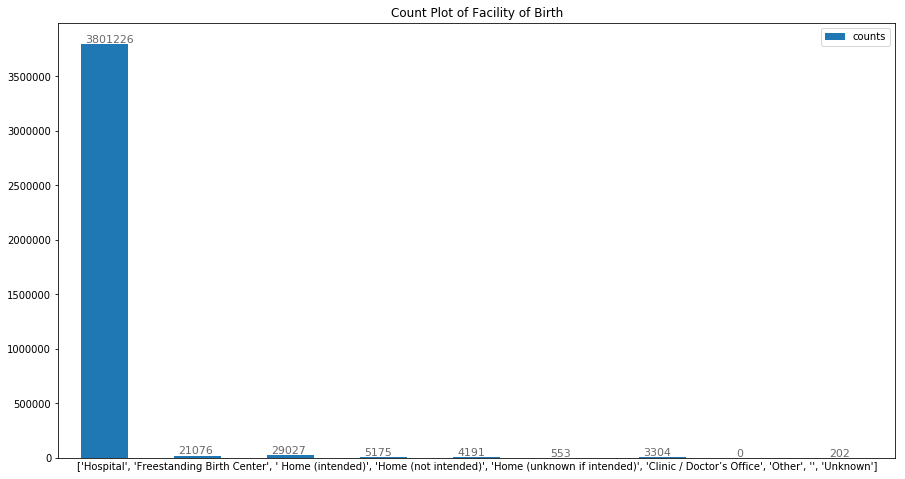

In [36]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111)
hist_birth_facility.set_index('bins'
            ).plot(kind='bar',figsize=(15,8),ax=ax)
ax.get_xaxis().set_ticks([])
ax.set_alpha(0.8)
ax.set_xlabel(['Hospital','Freestanding Birth Center',' Home (intended)','Home (not intended)','Home (unknown if intended)','Clinic / Doctor’s Office','Other','','Unknown'])
for i in ax.patches:
    ax.text(i.get_x()+.04, i.get_height()+12000, \
            str(round((i.get_height()), 2)), fontsize=11, color='dimgrey',
                )
plt.title('Count Plot of Facility of Birth')
plt.plot()

In [37]:
%%spark -o hist_delivery_route

hist_delivery_route =  spark.createDataFrame(
    list(zip(*delivery_route)), 
    ['bins', 'counts'])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

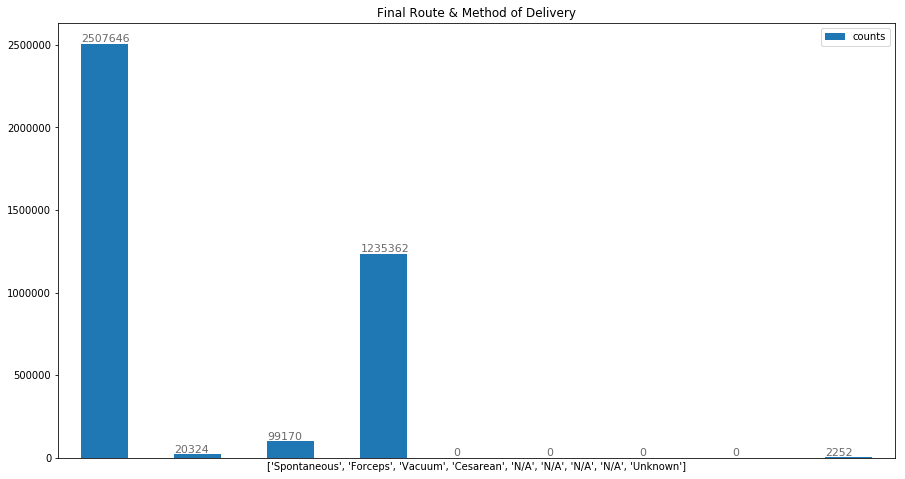

In [38]:
%matplotlib inline
ax = hist_delivery_route.set_index('bins'
            ).plot(kind='bar',figsize=(15,8))
for i in ax.patches:
    ax.text(i.get_x(), i.get_height()+13000, \
            str(round((i.get_height()), 2)), fontsize=11, color='dimgrey',
                )
ax.get_xaxis().set_ticks([])
ax.set_alpha(0.8)
ax.set_xlabel(['Spontaneous','Forceps','Vacuum','Cesarean','N/A','N/A','N/A','N/A','Unknown'])    
plt.title('Final Route & Method of Delivery')
plt.show()

#### d) Relationship between mother BMI and birthweight?

We are curious if there is any correlation between mother's and baby's weight. However as from the scatterplot, there does not seem any correlation between them.

Similar to mother's age and smoking habit. There is no strong correlation between them


In [39]:
%%spark -o scatter
#spark magic moves dataframe to local
scatter = (
    birth
    .select('bmi', 'dbwt')
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [211]:
%%local
from bokeh.io import show
from bokeh.plotting import figure
from bokeh.io import output_notebook
output_notebook()
p = figure(title = 'Relationship between mother BMI and birthweight')
p.xaxis.axis_label = 'BMI'
p.yaxis.axis_label = 'BirthWeight (in grams)'

p.circle(  list(scatter['bmi'])
         , list(scatter['dbwt'])
         , fill_alpha=0.2, size=10)

show(p)

Loading BokehJS ...

In [109]:
%%spark -o scatter
#spark magic moves dataframe to local
scatter = (
    birth.filter(condition_null)
    .select('cig_1', 'mager')
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [110]:
%%local
output_notebook()
p = figure(title = 'Relationship between mother smoking habit and her age')
p.xaxis.axis_label = 'Number of Daily Cigarettes in First Trimester'
p.yaxis.axis_label = 'Mother Age'

p.circle(  list(scatter['cig_1'])
         , list(scatter['mager'])
         , fill_alpha=0.2, size=10)

show(p)

Loading BokehJS ...

#### C. Handling Missing Observations:

By visualizing the distribution, it can be seen that most of missing observations are coded as 99/9 in many cases. Therefore, these would be cleaned.

First, we choose only the columns that potentially helpful for our model building purpose:

In [82]:
#List of columns to keep
cols_to_keep = ['mager','ilive','me_rout','ld_indl','no_risks','previs','cig_1','bmi','no_infec']
cat_cols = ['me_rout','ld_indl','no_risks','previs','no_infec']
#Select only those column
birth_subset = birth.select(cols_to_keep)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [70]:
#Examine the count of values in categorical to understand how missing value is coded, together with using the data dictionary 
#from the souce:
rdd_cat = (
    birth_subset
    .select(cat_cols + ['ilive'])
    .rdd
    .map(lambda row: [e for e in row])
)

#Create an empty dictionary
results_cat = {}

for i, col in enumerate(cat_cols + ['ilive']):
    results_cat[col] = (
        rdd_cat
        .groupBy(lambda row: row[i]) #group by distinct values in column i
        .map(lambda el: (el[0], len(el[1]))) #map to (category name, count)
        .collect()
    )
    
#print the results
for k in results_cat:
    print(
        k #column name, dictionary key
        , sorted( #sort by frequency of each category, descending
            results_cat[k] #print results
            , key=lambda el: el[1] #use frequency for sorting
            , reverse=True)
        , '\n')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

ilive [('Y', 3848096), ('N', 10218), ('U', 6440)] 

me_rout [(1, 2507646), (4, 1235362), (3, 99170), (2, 20324), (9, 2252)] 

ld_indl [('N', 2868959), ('Y', 993349), ('U', 2446)] 

no_risks [(1, 2696943), (0, 1164025), (9, 3786)] 

previs [(12, 600237), (10, 510583), (11, 376693), (13, 367822), (14, 313689), (9, 250326), (15, 242996), (8, 211345), (7, 132480), (16, 121609), (6, 105583), (99, 97986), (5, 79474), (0, 66824), (17, 59797), (4, 56012), (18, 47135), (20, 44112), (3, 40067), (2, 28393), (19, 25857), (1, 17314), (21, 13019), (22, 10522), (25, 8500), (23, 7487), (24, 6468), (30, 5128), (26, 3258), (27, 2450), (28, 2197), (29, 1378), (40, 1003), (32, 828), (35, 810), (31, 803), (33, 579), (39, 554), (34, 540), (38, 500), (36, 493), (37, 376), (49, 334), (41, 198), (42, 145), (45, 143), (50, 103), (43, 94), (44, 93), (46, 87), (47, 85), (48, 80), (60, 32), (55, 12), (52, 11), (54, 10), (56, 9), (57, 9), (72, 7), (51, 7), (53, 6), (59, 5), (61, 5), (75, 4), (58, 4), (98, 4), (70, 

In [77]:
#Filter out the value where encoded as unknown or no documneted
birth_subset_nonull = birth_subset.filter((birth_subset.ilive != 'U') & (birth_subset.no_risks != 9)
                                          & (birth_subset.me_rout != 9) & (birth_subset.previs !=99) & 
                                          (birth_subset.no_infec !=9) & (birth_subset.ld_indl != 'U') &
                                         (birth_subset.bmi != 99.9) & (birth_subset.cig_1 != 99))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [79]:
no_null_count = birth_subset_nonull.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [81]:
print('The cleaning process has removed {} cases'.format(rows - no_null_count))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The cleaning process has removed 206022 cases

In [111]:
descriptive_stats = birth_subset_nonull.describe(['cig_1','previs','bmi','mager'])
descriptive_stats.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------------+------------------+------------------+-----------------+
|summary|             cig_1|            previs|               bmi|            mager|
+-------+------------------+------------------+------------------+-----------------+
|  count|           3658732|           3658732|           3658732|          3658732|
|   mean|0.7116050041380456|11.341786444046736|26.978012273098482|28.85527199040542|
| stddev|3.4374776287607087|  4.15208061002399| 6.700234623342449|5.806033805750309|
|    min|                 0|                 0|              13.0|               12|
|    max|                98|                98|              68.9|               50|
+-------+------------------+------------------+------------------+-----------------+

As from the previous analysis, we would not exclude the outlier in cig_1 and previs since it might contain interesting correlation towards natal mortality.